## Step 2: Spectral extraction

### Overview

In Step 1, we remapped PL frames according to the PSF peak locations. Now we extract spectrum from these frames. To proceed, we need nonlinearity models and spectrum models ready. These steps are described in `pre1_nonlinearity_correction.ipynb` and `pre2_spectrum_model.ipynb` in this directory.


**Prerequisites** (complete these first):
- [Nonlinearity Correction](pre1_nonlinearity_correction.ipynb) - Generate detector nonlinearity models
- [Spectrum Model](pre2_spectrum_model.ipynb) - Create wavelength calibration and extraction models

**Tutorial Series**:
- [Step 1: Frame sorting](../../tutorials/step1_frame_sorting.ipynb) 
- [Step 3: Image reconstruction](../../tutorials/step3_image_reconstruction.ipynb) 



In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import h5py
import os, glob
import sys
from scipy.sparse import load_npz
from tqdm import tqdm
import json

import PLred.visPLred.preprocess as pp
import PLred.visPLred.spec as sp
import PLred.visPLred.parameters as par

In [8]:
# load data
data_dir = '../../tutorials/remapped/'
data_header = 'remapped'
dark_file = '../../tutorials/data/slowcam/dark.fits'
dark = fits.getdata(dark_file)

with open(data_dir+data_header+'_info.json', 'r') as file:
    map_info = json.load(file)
n = map_info['map_n']


In [19]:
# load nonlinearity model
modelname = 'nonlinmodel/global_nonlinearity_model'
xrange = np.r_[1100:1300] # this is the range we made nonlinearity model for

In [7]:
# load specmodel
specmodel = 'specmodel/'
matrix = load_npz(specmodel+'specmodel_matrix.npz')
info = np.load(specmodel+'specmodel_info.npy', allow_pickle=True).item()
xmin, xmax = int(info['xmin']), int(info['xmax'])
wav_map = np.load(specmodel+'specmodel_wavmap.npy')

Let's try extracting spectrum of one of the bins

In [12]:
# load data
with h5py.File(data_dir+data_header+'_bin_2_2.h5', 'r') as f:
    mapdata = f['rawframes'][:,:,xrange]
print(f"number of frames: {mapdata.shape[0]}")

number of frames: 9


In [16]:
# average frames
avgframe = np.nanmean(mapdata, axis=0)
# defining the full frame. the full frame size is required for spectral extraction model 
# but it's okay to be filled with zeros outside the range of interest.
avgframe_full = np.zeros((par.firstcam_params['size_y'], par.firstcam_params['size_x']))
avgframe_full[:, xrange] = avgframe

In [17]:
# dark subtraction
im_to_correct = avgframe_full - dark


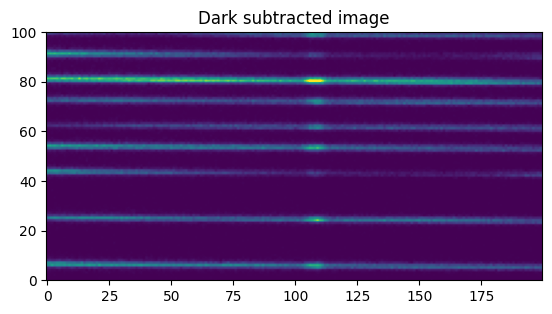

In [30]:
plt.imshow(im_to_correct[:,xrange], vmin=0, vmax=700)
plt.ylim([0,100])
plt.title('Dark subtracted image')
plt.show()

In [20]:
# nonlinearity correction
model = pp.DetectorNonlinearityModel(modelname)
corrected_map, status = model.correct_map(im_to_correct[:, xrange])

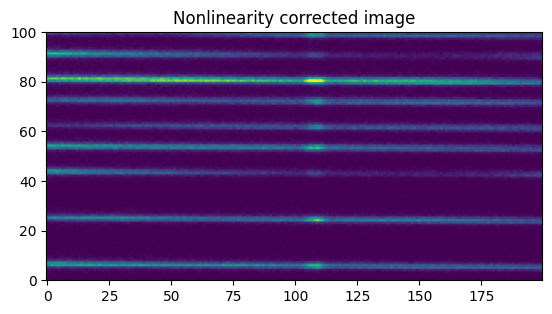

In [31]:
plt.imshow(corrected_map, vmin=0, vmax=700)
plt.ylim([0,100])
plt.title('Nonlinearity corrected image')
plt.show()

We don't see improvement in pixel-to-pixel variation here because we used a global nonlinearity correction model (for this dataset, the flat-field sequence was not available. The spectral traces do not align with the flat-field data that were taken later). But global correction is still necessary if there is emission/absorption feature.

In [32]:
# spectral extraction
frame = im_to_correct.copy()
frame[:, xrange] = corrected_map # patch the corrected map to the full frame
spec, res = sp.frame_to_spec(frame, xmin, xmax, wavmap = wav_map, matrix = matrix, return_residual = True,
                                badpix = None)

Now plot the extracted spectrum

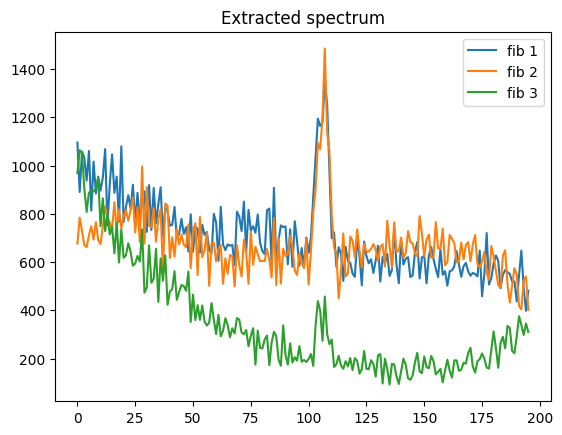

In [41]:
for fibind in range(3):
    plt.plot(spec[fibind][2:-2], label = f'fib {fibind+1}')

plt.legend()
plt.title('Extracted spectrum')
plt.show()

We can do this step for every h5 file. In this example we simply averaged the frames and did nonlinearity correction and spectral extraction, but we can bootstrap resample the frames and do the same process to get bootstrap spectrum samples. These can be used to calculate variance spectrum. We will skip bootstrap calculation here because there are only a few frames per bin.

Extract spectra and save

In [ ]:
# load mapfiles
mapfiles = [data_dir+data_header+'_bin_%d_%d.h5' % (i, j) for i in range(n) for j in range(n)]

nframes_cut = 1
nboot = 0
skip_if_exists = False


def rawframe_to_spec(rawframe, dark,
                     nonlinearity_model,
                     matrix,
                     xmin, xmax, wav_map):

    im_to_correct = (rawframe - dark)#[:,xrange]
    # print(np.shape(im_to_correct))

    print("start correcting nonlinearity")
    # nonlinearity correction
    model = pp.DetectorNonlinearityModel(modelname =nonlinearity_model)
    corrected_map, status = model.correct_map(im_to_correct[:, xrange])
    mask = corrected_map *0 != 0 # there are some NaNs that failed nonlinearity correction

    # patch correction
    frame = im_to_correct.copy()
    frame[:,xrange] = corrected_map
    badpix = np.zeros_like(frame, dtype=bool)
    badpix[:,xrange] = mask

    print("start extracting spectrum")
    # extract spectrum
    spec, res = sp.frame_to_spec(frame, xmin, xmax, wavmap = wav_map, matrix = matrix, return_residual = True,
                                 badpix = badpix)

    return spec



for mapfile in tqdm(mapfiles):


    if not os.path.exists(mapfile):
        print("file %s does not exist" % mapfile)
        continue

    if skip_if_exists and os.path.exists(mapfile.replace('.h5', '_spec.h5')):
        print("file %s already exists, skipping" % mapfile.replace('.h5', '_spec.h5'))
        continue
    
    print("processing %s" % mapfile)
    
    # load map
    with h5py.File(mapfile, 'r') as f:
        mapdata = f['rawframes'][:,:,xrange]

    nframes = mapdata.shape[0]
    if nframes < nframes_cut:
        print("file %s has only %d frames, skipping" % (mapfile, nframes))
        continue

    # create hdf5 file
    outname = mapfile.replace('.h5', '_spec.h5')
    with h5py.File(outname, 'w') as h5file:
        print("creating %s" % outname)
        h5file.attrs['num_frames'] = nframes

        avgspec_h5 = h5file.create_dataset('avgspec', shape = (38, xmax-xmin))
        bootspec_h5 = h5file.create_dataset('bootspecs', shape = (nboot, 38, xmax-xmin))

        # get average
        avgframe = np.nanmean(mapdata, axis=0)
        avgframe_full = np.zeros((par.firstcam_params['size_y'], par.firstcam_params['size_x']))
        avgframe_full[:, xrange] = avgframe

        # get average spectrum
        avgspec = rawframe_to_spec(avgframe_full, dark, modelname, matrix, xmin, xmax, wav_map)
        avgspec_h5[:] = avgspec

        # skip bootstrapping (nboot is set to 0)
        for i in tqdm(range(nboot)):
            print("bootstrapping %d" % i)
            # get bootstrapped index
            boot_ind = np.random.choice(nframes, nframes, replace=True)

            # get bootstrapped spectrum
            bootframes = mapdata[boot_ind]
            bootframe = np.average(bootframes, axis=0)
            bootframe_full = np.zeros((412, 1896))
            bootframe_full[:, xrange] = bootframe
            spec = rawframe_to_spec(bootframe_full, dark, modelname, matrix, xmin, xmax, wav_map)
            # bootspecs.append(spec)
            # save bootstrapped spectrum
            # bootspec_h5[i] = spec

            # with h5py.File(outname, 'r+') as h5f:
            #     h5f['bootspecs'][i] = spec
            bootspec_h5[i] = spec

  0%|          | 0/25 [00:00<?, ?it/s]

file ../../tutorials/remapped/remapped_bin_0_0.h5 does not exist
file ../../tutorials/remapped/remapped_bin_0_1.h5 does not exist
processing ../../tutorials/remapped/remapped_bin_0_2.h5
creating ../../tutorials/remapped/remapped_bin_0_2_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 12%|█▏        | 3/25 [00:02<00:18,  1.19it/s]

processing ../../tutorials/remapped/remapped_bin_0_3.h5
creating ../../tutorials/remapped/remapped_bin_0_3_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 16%|█▌        | 4/25 [00:04<00:27,  1.31s/it]

file ../../tutorials/remapped/remapped_bin_0_4.h5 does not exist
file ../../tutorials/remapped/remapped_bin_1_0.h5 does not exist
processing ../../tutorials/remapped/remapped_bin_1_1.h5
creating ../../tutorials/remapped/remapped_bin_1_1_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 28%|██▊       | 7/25 [00:07<00:19,  1.06s/it]

processing ../../tutorials/remapped/remapped_bin_1_2.h5
creating ../../tutorials/remapped/remapped_bin_1_2_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 32%|███▏      | 8/25 [00:10<00:24,  1.42s/it]

processing ../../tutorials/remapped/remapped_bin_1_3.h5
creating ../../tutorials/remapped/remapped_bin_1_3_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 36%|███▌      | 9/25 [00:12<00:25,  1.58s/it]

file ../../tutorials/remapped/remapped_bin_1_4.h5 does not exist
file ../../tutorials/remapped/remapped_bin_2_0.h5 does not exist
processing ../../tutorials/remapped/remapped_bin_2_1.h5
creating ../../tutorials/remapped/remapped_bin_2_1_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 48%|████▊     | 12/25 [00:14<00:16,  1.24s/it]

processing ../../tutorials/remapped/remapped_bin_2_2.h5
creating ../../tutorials/remapped/remapped_bin_2_2_spec.h5
start correcting nonlinearity
start extracting spectrum


0it [00:00, ?it/s]
 52%|█████▏    | 13/25 [00:17<00:18,  1.53s/it]

processing ../../tutorials/remapped/remapped_bin_2_3.h5
creating ../../tutorials/remapped/remapped_bin_2_3_spec.h5
start correcting nonlinearity


Now we have generated `remapped_bin_i_j_spec.h5` files. We will remap make response maps from these files in Step 3.